# Sea Waves Analysis

This notebook analyzes sea wave parameters using multivariate normal distribution. It includes data simulation, statistical testing, and plotting of results.

## Import Libraries

We begin by importing the necessary libraries.


In [26]:
from termcolor import colored

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcol

from sklearn.model_selection import train_test_split

import scipy.stats as scs
import numpy as np

## Define Functions

Next, we define a function to calculate the covariance matrix.


In [36]:
def calvar(x,p):
    mu = np.sum(x*p)
    return np.sum(p*(x-mu)**2)

def calcov(x,y,pxy):
    xy = []
    for xx in x:
        xy = np.append(xy,xx*y)
    xy = xy.reshape(-1,y.shape[0])

    Ex,Ey,Exy = sum(pxy.T@x).round(4),sum(pxy@y).round(4),np.sum(xy*pxy).round(4)
    Cxx,Cyy = calvar(x,np.sum(pxy,axis=1)),calvar(y,np.sum(pxy,axis=0))
    Cxy = Exy-Ex*Ey
    cov = np.array([[Cxx,Cxy],[Cxy,Cyy]])
    mu  = np.array([Ex,Ey])
    return (cov,mu)

def ztest(x,mp,sp,z_crit,alfa):

    n  = len(x)
    mx = np.mean(x)
    sm = sp/np.sqrt(n)
    zs = (mx-mp)/sm
    pv = 1-scs.norm.cdf(zs)

    print('Samples data')
    print(' Number:',n)
    print('   Mean:',mx)

    # Hypothesis
    if zs >  zsc:
        print (colored('Reject Null Hypothesis','green'))
    else:
        print (colored('Fail to Reject Null Hypothesis','red'))

    #if pv < alfa:
        #print('Reject Null Hypothesis')
    #else:
        #print('Fail to Reject Null Hypothesis')
    return(zs,pv)

## Load and Process Data

We load the data from the CSV file and preprocess it.


In [37]:
iDir,pDir = 'input/','plots/'
df = pd.read_csv(iDir + 'wav_scat.csv', sep=';', index_col=0)

df.index = df.index.values
df.columns = df.columns.values.astype(float)
#df = df.reindex(sorted(df.columns), axis=1)

vhs, vte = df.index.values, df.columns.values.astype(float)
dvt, dvh = np.mean(np.diff(vte)), np.mean(np.diff(-vhs))
pht = df.values

display(df.head())

phs = df.sum(axis=1) / 1e2  ### probability of wave height
pte = df.sum(axis=0) / 1e2  ### probability of energy period

cov,mu = calcov(vte,vhs,pht.T/1e2)  ### calculate vector of means and covariance matrix of scatter data

te    = [min(vte), max(vte)]
hs    = [min(vhs), max(vhs)]
nDati = df.shape[0]*df.shape[1]
print()
print('   No.Data:', nDati)
print('      Mean:', mu)
print('Covariance:', cov)

,4.75,5.25,5.75,6.25,6.75,7.25,7.75,8.25,8.75,9.25,9.75,10.25,10.75,11.25,11.75,12.25,12.75,13.25,13.75,14.25
13.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
13.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.01
12.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.02,0.00
12.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
11.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.00



   No.Data: 560
      Mean: [8.8278 2.3452]
Covariance: [[2.32329565 0.97194344]
 [0.97194344 1.45546338]]


## Simulate Data

We simulated the data based on the defined parameters *cov* and *mu*. Finally, some noise was added to the generated random bivariates.


In [38]:
rnd_seed = 60306

distr = scs.multivariate_normal(cov=cov, mean=mu, seed=rnd_seed)

nData = 13189 #### acc. to [1]

fdat = distr.rvs(size=nData)

hsg, teg = np.meshgrid(vhs, vte)
fpdf = distr.pdf(fdat)

k = np.where(fdat[:, 0] < min(te))[0]
fdat[k, 0] = min(te)

k = np.where(fdat[:, 1] < min(hs))[0]
fdat[k, 1] = min(hs)

##### Adding some noise to normally distributed data
ste = np.std(vte*pte)
shs = np.std(vhs*phs)

np.random.seed(rnd_seed)

t_noi = np.random.normal(0.0, ste, nData)
h_noi = np.random.normal(0.0, shs, nData)

fndat = fdat + np.array([t_noi, h_noi]).T

k = np.where(fndat[:, 0] < min(te))[0]
fndat[k, 0] = min(te)

k = np.where(fndat[:, 1] < min(hs))[0]
fndat[k, 1] = min(hs)

## Perform Hypothesis Test

We perform a one-tailed z-test to test the hypothesis about sea waves. Hypothesis is built on the measure of sea
development, as a ratio of wave period to square root of wave height: $c_{TH}=\frac{T_e}{\sqrt{H_s}}$. The fully developed seas are
quantified by $c_{TH}\ge 4.33$ and alternatively partially developed seas are
quantified by $c_{TH}<4.33$. 


In [39]:
period,height = fndat[:,0],fndat[:,1]

vLbl = (r'$\mu$:',r'$\sigma$:',r'$n_{SAMPLES}$:',r'$\alpha$:',r'$z_{CRiT}$:',r'$z_{SCORE}$:',r'$p-val$:')
pLbl = ('Mean:','St.Dev.:','Num.Samp.:','Sign.Lvl:','Z.Value:','Z.Score:','p.val')
vFmt = ('%6.2f','%6.2f','%6.0f','%6.2f','%6.2f','%6.2f','%6.2f')

#Hypothesis
# cht = Period / sqrt(Height)
# H0 >> Non-developed seas (offshore sea, relatively shallow seas): cht < 4.33
# H1 >> Fully developed seas (oceans, open sea areas): cht > 4.33

#### Samples for hypothesis test
cht = period / np.sqrt(height)

#### Population data
mcht_p = 4.33
scht_p = np.std(cht)

print('Population data:')
print('Mean:',mcht_p)
print(' Std:',scht_p)

alf = 5e-2                 ### significance level
zsc = scs.norm.ppf(1-alf)  ### critical z-score for signigicance level

Population data:
Mean: 4.33
 Std: 2.352410924892607


A hypothesis test was carried out for a large sample, representing approximately 10% of the entire generated data, and for a small sample, slightly above 30, in line with the Central Limit Theorem. The samples were then randomly selected from the entire population of *cht*.

In [40]:
N = {'L': int(0.1*nData), 'S': 32}

#### Large Sample
t_size = np.round(N['L']/nData,1)

_,cht_s = train_test_split(cht,test_size=t_size)
print()
zs,pv = ztest(cht_s,mcht_p,scht_p,zsc,alf)
vVal = (mcht_p,scht_p,len(cht_s),alf,zsc,zs,pv)
dfo = pd.Series(dict(zip(pLbl,vVal))).round(4)
print()
display(dfo)
#dfo.to_csv('Test-L.csv',sep=';')

#### Small Sample
t_size = N['S']/nData
_,cht_s = train_test_split(cht,test_size=t_size)
print()
zs,pv = ztest(cht_s,mcht_p,scht_p,zsc,alf)
vVal = (mcht_p,scht_p,len(cht_s),alf,zsc,zs,pv)
dfo = pd.Series(dict(zip(pLbl,vVal))).round(4)
print()
display(dfo)


Samples data
 Number: 1319
   Mean: 6.490702435099064
Reject Null Hypothesis



Mean:            4.3300
St.Dev.:         2.3524
Num.Samp.:    1319.0000
Sign.Lvl:        0.0500
Z.Value:         1.6449
Z.Score:        33.3583
p.val            0.0000
dtype: float64


Samples data
 Number: 32
   Mean: 6.413048982703263
Reject Null Hypothesis



Mean:          4.3300
St.Dev.:       2.3524
Num.Samp.:    32.0000
Sign.Lvl:      0.0500
Z.Value:       1.6449
Z.Score:       5.0091
p.val          0.0000
dtype: float64

## Plot Results

We generate plots to visualize the results of the analysis.

In [41]:
s_title = 'Original Data (Atlantinc Marine Energy Test Site)'
p_title = 'Estimated Data (Atlantinc Marine Energy Test Site)'
LBL = ('Period, [s]','Wave height, [m]')

xMin,xMax = (0,16)
yMin,yMax = (0,16)
dx,dy  = (4,2/3)
p_linewidth = 2
p_col= '#0088cc'
p_alpha = 0.6
p_size  = 40

l_col = np.array([4,4,4])/255
p_col = [x/255 for x in [250,140,80]]
l_col = '#1e1e1e'
p_col = '#f0a06e'
cMap  = 'PuRd'

cmap = plt.get_cmap(cMap)
num_colors = 10
hex_col = [mcol.to_hex(cmap(i / num_colors)) for i in range(num_colors)]

p_col = hex_col[4]
l_col = hex_col[-4]

teg,hsg = np.meshgrid(vte,vhs)

### Plot of original data

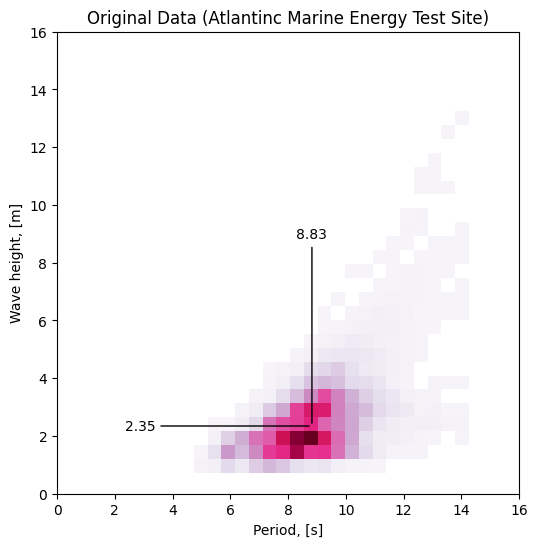

In [42]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_title(s_title)
cax = ax.imshow(df.replace(0,np.nan).values, aspect='auto', cmap=cMap, origin='upper',
                extent=[min(vte), max(vte), min(vhs), max(vhs)])

ax.annotate('%.2f'%mu[0],xytext=(mu[0],mu[0]),xy=(mu[0],mu[1]),ha='center',arrowprops=dict(facecolor='black', arrowstyle='-'))
ax.annotate('%.2f'%mu[1],xytext=(mu[1],mu[1]),xy=(mu[0],mu[1]),va='center',arrowprops=dict(facecolor='black', arrowstyle='-'))

ax.set_xlim(0,16)
ax.set_ylim(0,16)
ax.set_xlabel(LBL[0])
ax.set_ylabel(LBL[1])
ax.set_aspect(1)

fig.savefig(pDir + 'scatter.png',dpi=300)

### Plot of generated data

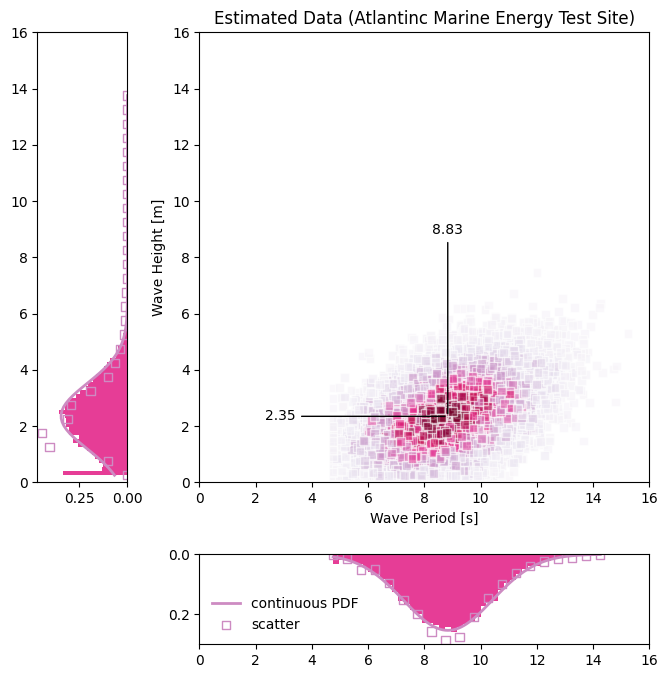

In [43]:
fig,ax = plt.subplots(1,figsize=(9,9))

ax.set_title(p_title)
ax.scatter(fndat[:,0],fndat[:,1],ec='white',marker='s',alpha=p_alpha,
           s=p_size,c=fpdf,cmap=cMap,linewidths=None)
#ax.text(xMin+dx,yMax-dy,'Z-Score test',weight='bold')
#for i,l in enumerate(vLbl):
    #LBL = vFmt[i]%(vVal[i])
    #ax.text(xMin+dx,yMax-(i+2)*dy,LBL,va='top',ha='left')
    #ax.text(xMin+dx,yMax-(i+2)*dy,l,va='top',ha='right')

ax.annotate('%.2f'%mu[0],xytext=(mu[0],mu[0]),xy=(mu[0],mu[1]),ha='center',arrowprops=dict(facecolor='black', arrowstyle='-'))
ax.annotate('%.2f'%mu[1],xytext=(mu[1],mu[1]),xy=(mu[0],mu[1]),va='center',arrowprops=dict(facecolor='black', arrowstyle='-'))
ax.set_xlim(xMin,xMax)
ax.set_ylim(yMin,yMax)
ax.set_xlabel('Wave Period [s]')
ax.set_ylabel('Wave Height [m]')
ax.set_aspect(1)

l,b,w,h=ax.get_position().bounds

ax.set_position([.3,.3,.5,.5])
l,b,w,h=ax.get_position().bounds

nd = np.shape(fdat)[1]
pvec = np.array([[l,.12,w,.1],[.12,b,.1,h]])
argMin = (min(te),min(hs))
argMax = (max(te),max(hs))
hor = ['vertical','horizontal']
xd,yd = [vte,vhs],[pte/dvt,phs/dvh]
for i in range(nd):

    axt = fig.add_axes(pvec[i,:])

    y = fndat[:,i]
    xMin,xMax = (argMin[i],argMax[i])
    std = np.std(y)
    mean = np.mean(y)

    x = np.linspace(xMin,xMax,101)
    pdf = scs.norm.pdf(x,mean,std)

    kwargs = dict(histtype='bar',align='mid',color=l_col,rwidth=1, 
                  alpha=.96, density=True, bins=50, orientation=hor[i])

    ns,_,patches = axt.hist(y,**kwargs)

    if hor[i]=='horizontal':
        axt.plot(pdf,x,'-',color=p_col,lw=p_linewidth)
        axt.scatter(yd[i],xd[i],marker='s', c='none', edgecolors=p_col)
        axt.set_ylim(yMin,yMax)
        axt.invert_xaxis()
    else:
        axt.plot(x,pdf,'-',color=p_col,lw=p_linewidth,label='continuous PDF')
        axt.scatter(xd[i],yd[i],c='none',marker='s', edgecolors=p_col,label='scatter')
        axt.set_xlim(yMin,yMax)
        axt.invert_yaxis()
        axt.legend(frameon=False)

fig.savefig(pDir + 'population.png',dpi=300)